In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import os
import cv2
import timm

import albumentations
from albumentations import pytorch as AT

#below are all from https://github.com/seefun/TorchUtils, thanks seefun to provide such useful tools
import torch_utils as tu


D:\Anaconda\envs\CL\Lib\site-packages\torch_utils\models\cls_models\simple_cls_model.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()
D:\Anaconda\envs\CL\Lib\site-packages\torch_utils\models\seg_models\unet.py:355: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @ autocast()


## 加载数据集

In [2]:
CLEAN_DATASET = 0
FOLD = 5
csv = pd.read_csv('train.csv') 
sfolder = StratifiedKFold(n_splits=FOLD,random_state=709,shuffle=True)
train_folds = []
val_folds = []
for train_idx, val_idx in sfolder.split(csv['image'], csv['label']):
  train_folds.append(train_idx)
  val_folds.append(val_idx)
  print(len(train_idx), len(val_idx))

14682 3671
14682 3671
14682 3671
14683 3670
14683 3670


In [3]:
labelmap_list = sorted(list(set(csv['label']))) #sorting is necessary to reproduce the order of the labelmap
labelmap = dict()
for i, label in enumerate(labelmap_list):
  labelmap[label] = i
print(labelmap)

{'abies_concolor': 0, 'abies_nordmanniana': 1, 'acer_campestre': 2, 'acer_ginnala': 3, 'acer_griseum': 4, 'acer_negundo': 5, 'acer_palmatum': 6, 'acer_pensylvanicum': 7, 'acer_platanoides': 8, 'acer_pseudoplatanus': 9, 'acer_rubrum': 10, 'acer_saccharinum': 11, 'acer_saccharum': 12, 'aesculus_flava': 13, 'aesculus_glabra': 14, 'aesculus_hippocastamon': 15, 'aesculus_pavi': 16, 'ailanthus_altissima': 17, 'albizia_julibrissin': 18, 'amelanchier_arborea': 19, 'amelanchier_canadensis': 20, 'amelanchier_laevis': 21, 'asimina_triloba': 22, 'betula_alleghaniensis': 23, 'betula_jacqemontii': 24, 'betula_lenta': 25, 'betula_nigra': 26, 'betula_populifolia': 27, 'broussonettia_papyrifera': 28, 'carpinus_betulus': 29, 'carpinus_caroliniana': 30, 'carya_cordiformis': 31, 'carya_glabra': 32, 'carya_ovata': 33, 'carya_tomentosa': 34, 'castanea_dentata': 35, 'catalpa_bignonioides': 36, 'catalpa_speciosa': 37, 'cedrus_atlantica': 38, 'cedrus_deodara': 39, 'cedrus_libani': 40, 'celtis_occidentalis': 41

In [4]:
class LeavesDataset(Dataset):
  def __init__(self, csv, transform=None):
    self.csv = csv
    self.transform = transform
  
  def __len__(self):
    return len(self.csv['image'])
  
  def __getitem__(self, idx):
    img = cv2.imread(self.csv['image'][idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = labelmap[self.csv['label'][idx]]
    if self.transform:
      img = self.transform(image = img)['image']
    return img, torch.tensor(label).type(torch.LongTensor)

def create_dls(train_csv, test_csv, train_transform, test_transform, bs, num_workers):
  train_ds = LeavesDataset(train_csv, train_transform)
  test_ds = LeavesDataset(test_csv, test_transform)
  train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=True)
  test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False)
  return train_dl, test_dl, len(train_ds), len(test_ds)

In [5]:
train_transform1 = albumentations.Compose([
    albumentations.Resize(112, 112, interpolation=cv2.INTER_AREA),
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.0625, rotate_limit=45, border_mode=1, p=0.5),
    #tu.randAugment(N=2,M=6,p=1,cut_out=True),    
    albumentations.Normalize(),
    AT.ToTensorV2(),
    ])
    
test_transform1 = albumentations.Compose([
    albumentations.Resize(112, 112, interpolation=cv2.INTER_AREA),
    albumentations.Normalize(),
    AT.ToTensorV2(),
    ])

## 测试数据集

In [6]:
class LeavesTestDataset(Dataset):
  def __init__(self, csv, transform=None):
    self.csv = csv
    self.transform = transform
  
  def __len__(self):
    return len(self.csv['image'])
  
  def __getitem__(self, idx):
    img = Image.open(self.csv['image'][idx])
    if self.transform:
      img = self.transform(img)
    return img

def create_testdls(test_csv, test_transform, bs):
  test_ds = LeavesTestDataset(test_csv, test_transform)
  test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=2)
  return test_dl

transform_test = transforms.Compose([
        transforms.Resize((112,112)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

In [7]:
def show_img(x):
  trans = transforms.ToPILImage()
  mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
  std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
  x = (x*std)+mean
  x_pil = trans(x)
  return x_pil

## Show images with the first fold data

In [8]:
train_csv = csv.iloc[train_folds[0]].reset_index()
val_csv = csv.iloc[val_folds[0]].reset_index()

In [9]:
train_dl, val_dl, n_train, n_val = create_dls(train_csv, val_csv, train_transform=train_transform1, test_transform=test_transform1, bs=64, num_workers=4)

In [10]:
print(len(train_dl.dataset))

14682


In [11]:
import tqdm
with tqdm.tqdm(total=len(train_dl)) as pbar:  
    for x, y in train_dl:  
        pbar.update(1)

100%|██████████| 229/229 [00:25<00:00,  9.11it/s]


In [12]:
y.shape

torch.Size([64])

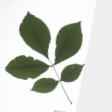

In [13]:
show_img((x[2]))

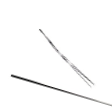

In [14]:
show_img((x[3]))

## Model
# Define the model. We use the pretrained model either from timm or torchvision. 

In [15]:
weight_path = './resnet50d_ra2-464e36ba.pth'    # 从下载链接下载其使用的预训练权重到本地
model = timm.create_model('resnet50d', pretrained=False)

In [16]:
# 加载权重  使用torch.load方法加载本地文件
model.load_state_dict(torch.load(weight_path, weights_only=True))

<All keys matched successfully>

In [17]:
model.fc = nn.Linear(model.fc.in_features, len(labelmap_list))
nn.init.xavier_uniform_(model.fc.weight);

In [18]:
model.cuda()
device = 'cuda'

In [19]:
# 检查torch cuda是否正确安装
print(torch.__version__)
print(torch.cuda.is_available())

2.4.0
True


# Optimizer, loss


In [20]:
class LabelSmoothing(nn.Module):
    """
    分类任务的损失函数，即带有标签平滑的负对数似然损失
    标签平滑是一种正则化技术，旨在提高模型的泛化能力
    通过减少对硬标签（即完全确定的标签）的依赖，并引入对模型不确定性的考虑
    在一定程度上解决模型可能会过拟合的问题
    """
    def __init__(self, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        # 前向传播计算负对数似然损失
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [21]:
params_1x = [param for name, param in model.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
lr = 5e-4

optimizer = torch.optim.AdamW([{'params': params_1x},
                                   {'params': model.fc.parameters(),
                                    'lr': lr * 10}],
                                lr=lr, weight_decay=0.001) #finetuning
'''
from optim import RangerLars
optimizer = RangerLars([{'params': params_1x},
                        {'params': model.fc.parameters(),
                                    'lr': lr * 10}], lr=lr, weight_decay=0.001)
'''
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)

loss_fn = LabelSmoothing(0.1)

# Find the LR

In [22]:
import math
import matplotlib.pyplot as plt
import numpy as np

def find_lr(model, factor, train_dl, optimizer, loss_fn, device, init_lr=1e-8, final_lr=1e-1, beta=0.98, plot=True, save_dir=None):
    num = len(train_dl) - 1
    mult = (final_lr / init_lr) ** (1/num)
    lr = init_lr
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    scaler = torch.cuda.amp.GradScaler() # for AMP training 

    if 1:
      for x, y in train_dl:
          x, y = x.to(device), y.to(device)
          batch_num += 1
          optimizer.zero_grad()
          with torch.cuda.amp.autocast():
            out = model(x)
            loss = loss_fn(out, y)
          #smoothen the loss
          avg_loss = beta * avg_loss + (1-beta) * loss.data.item() #check
          smoothed_loss = avg_loss / (1 - beta**batch_num) #bias correction
          #stop if loss explodes
          if batch_num > 1 and smoothed_loss > 4 * best_loss: #prevents explosion
              break
          #record the best loss
          if smoothed_loss < best_loss or batch_num == 1:
              best_loss = smoothed_loss
          #store the values
          losses.append(smoothed_loss)
          log_lrs.append(math.log10(lr))
          #do the sgd step
          #loss.backward()
          #optimizer.step()
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          #update the lr for the next step
          lr *= mult
          optimizer.param_groups[0]['lr'] = lr
    #Suggest a learning rate
    log_lrs, losses = np.array(log_lrs), np.array(losses)
    idx_min = np.argmin(losses)
    min_log_lr = log_lrs[idx_min]
    lr_auto = (10 ** (min_log_lr)) /factor
    if plot:
        selected = [np.argmin(np.abs(log_lrs - (min_log_lr-1)))] #highlight the suggested lr
        plt.figure()
        plt.plot(log_lrs, losses,'-gD', markevery=selected)
        plt.xlabel('log_lrs')
        plt.ylabel('loss')
        plt.title('LR Range Test')
        if save_dir is not None:
            plt.savefig(f'{save_dir}/lr_range_test.png')
        else:
            plt.savefig(f'lr_range_test.png')
    return lr_auto

In [23]:
def get_learner(lr, nb, epochs, model_name='resnet50d', MIXUP=0.1):
  mixup_fn = tu.Mixup(prob=MIXUP, switch_prob=0.0, onehot=True, label_smoothing=0.05, num_classes=len(labelmap_list))
  
  # 改为从本地加载
  model = timm.create_model(model_name, pretrained=False)
  model.load_state_dict(torch.load(weight_path, weights_only=True))
  
  model.fc = nn.Linear(model.fc.in_features, len(labelmap_list))
  nn.init.xavier_uniform_(model.fc.weight)
  model.cuda()

  params_1x = [param for name, param in model.named_parameters()
              if name not in ["fc.weight", "fc.bias"]]

  optimizer = torch.optim.AdamW([{'params': params_1x},
                                    {'params': model.fc.parameters(),
                                      'lr': lr*10}],
                                  lr=lr, weight_decay=2e-4)

  loss_fn = tu.SoftTargetCrossEntropy() if MIXUP else LabelSmoothing(0.1)
  loss_fn_test = F.cross_entropy

  import math
  def warmup_one_cycle(y1=0.0, y2=1.0, steps=100, warmup_steps=0): #no warmup is better experimentally
          #sinusoidal ramp from y1 to y2 https://arxiv.org/pdf/1812.01187.pdf
          return lambda x: x / warmup_steps if x < warmup_steps \
                          else ((1 - math.cos((x-warmup_steps) * math.pi / steps)) / 2) * (y2 - y1) + y1

  lf = warmup_one_cycle(1, 0.2, epochs*nb, 3*nb)
  #lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf) 
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5*nb, eta_min=lr_suggested/100)

  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*nb, eta_min=lr/20)
  return model, optimizer, loss_fn, loss_fn_test, lr_scheduler, mixup_fn

# Train

In [24]:
import torch  
  
# 检查CUDA是否可用  
if torch.cuda.is_available():  
    device = torch.device("cuda")  
    print("Running on GPU")  
else:  
    device = torch.device("cpu")  
    print("Running on CPU") 

Running on GPU


In [31]:
# Start training
import time
from tqdm import tqdm
import ttach as tta
device = 'cuda'
save_dir = './classfication_model'
#map from idx to string
labelmap_inverse = dict()
for key_ in labelmap.keys():
  labelmap_inverse[labelmap[key_]] = key_
EPOCHS = 50
MIXUP = 0.1
 
scaler = torch.cuda.amp.GradScaler() # for AMP training 

for fold in range(FOLD):
  print(f'Start Fold{fold}...')

  # 每一个fold加载不同的数据集，用于后面综合五个权重得到泛化能力更好的模型
  train_csv = csv.iloc[train_folds[fold]].reset_index()
  val_csv = csv.iloc[val_folds[fold]].reset_index()
  train_dl, val_dl, n_train, n_val = create_dls(train_csv, val_csv, train_transform=train_transform1, test_transform=test_transform1, bs=64, num_workers=4)
  model, optimizer, loss_fn, loss_fn_test, lr_scheduler, mixup_fn = get_learner(3e-4, len(train_dl), EPOCHS, model_name='resnet50d', MIXUP=MIXUP)
  model_name = f'5fold_test_fold{fold}'
  train_losses = [] 
  val_losses = []
  train_accus = []
  val_accus = []
  best_accu = 0
  best_loss = float('inf')
  lrs = []
  for epoch in range(EPOCHS):
          t1 = time.time()
          val_accu = 0
          train_accu = 0
          train_losses_tmp = []
          #Train
          model.train()
          t_inf = 0
          for x, y in train_dl:
              if MIXUP:
                x, y = mixup_fn(x, y)
              x, y = x.to(device), y.to(device)
              #Forward
              with torch.cuda.amp.autocast():
                pred = model(x)
                loss = loss_fn(pred, y)
              #Backward
              #loss.backward()
              #optimizer.step()
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()
              lr_scheduler.step()
              optimizer.zero_grad()
              #Statistics
              lrs.append(optimizer.param_groups[0]['lr']) #group 0,1,2 share the learning rate
              train_losses_tmp.append(loss.data.item())
              pred_labels = torch.argmax(pred.data, dim=1)
              y_labels = torch.argmax(y.data, dim=1) if MIXUP else y.data
              train_accu += (pred_labels==y_labels).float().sum()

          t_inf /= len(train_dl)
          train_losses.append(np.mean(np.array(train_losses_tmp)))
          train_accu /= n_train
          train_accus.append(train_accu.data.item())

          t2 = time.time()
          #Validation
          val_losses_tmp = []
          model.eval()
          with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                logit = model(x)
                val_loss = loss_fn_test(logit, y) 
                val_losses_tmp.append(val_loss.data.item())
                pred = torch.argmax(logit.data, dim=1)
                val_accu += (pred==y.data).float().sum()
          t3 = time.time()
          val_loss = np.mean(np.array(val_losses_tmp))
          val_losses.append(val_loss)
          val_accu /= n_val
          val_accus.append(val_accu.data.item())
          print('fold', fold, 'epoch', epoch, 'train_loss', train_losses[epoch], 'val_loss', val_losses[epoch], 'val_accu', val_accu, 'train_accu', train_accu, 'train time', t2-t1, 'val time', t3-t2, 'lr[0]', lrs[-1])
          if save_dir is not None:
              if val_accu == best_accu:
                  if val_loss < best_loss: #never satisfied
                      checkpoint = {"model": model.state_dict()}
                      torch.save(checkpoint, os.path.join(save_dir,f'{model_name}_best.pth'))
                      print(f'Stored a new best model in {save_dir}')
                      best_loss = val_loss
              elif val_accu > best_accu:
                  checkpoint = {"model": model.state_dict()}
                  torch.save(checkpoint, os.path.join(save_dir,f'{model_name}_best.pth'))
                  print(f'Stored a new best model in {save_dir}')
                  best_accu = val_accu
              '''
              if epoch == EPOCHS - 1:
                  checkpoint = {"model": model.state_dict()}
                  torch.save(checkpoint, os.path.join(save_dir,f'{model_name}_last.pth'))
                  print(f'Stored the last model in {save_dir}')
              '''
  # test time
  test_csv = pd.read_csv('test.csv')
  test_dl = create_testdls(test_csv, transform_test, bs=8)
  model.eval()
  tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.flip_transform(),  merge_mode='mean')
  tta_model.eval()
  res = []
  for x in test_dl:
      x = x.to(device)
      logit = tta_model(x)
      pred = torch.argmax(logit.data, dim=1).cpu().numpy()
      for i in range(len(pred)):
          res.append(labelmap_inverse[pred[i]])
  test_csv.insert(1, 'label', res)
  test_csv.to_csv((f'submission_e50{model_name}_fold{fold}.csv'), index=False)
  print('test cvs is saved')

C:\Users\Eligah\AppData\Local\Temp\ipykernel_9620\3847396346.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # for AMP training


Start Fold0...


C:\Users\Eligah\AppData\Local\Temp\ipykernel_9620\3847396346.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


fold 0 epoch 0 train_loss 2.3804831858805695 val_loss 0.8001003537712426 val_accu tensor(0.7753, device='cuda:0') train_accu tensor(0.5128, device='cuda:0') train time 27.40842843055725 val time 4.251707315444946 lr[0] 0.0002997188088010285


RuntimeError: File ../best_model_path\5fold_test_fold0_last.pth cannot be opened.

In [ ]:
plt.plot(train_accus)
plt.plot(val_accus)
plt.plot(train_losses)
plt.plot(val_losses)
plt.ylim(0, 1.3)
plt.legend(['train_accus', 'val_accus', 'train_losses', 'val_losses'])
#plt.show()
plt.title('Learning Curve')
plt.xlabel('epochs')

plt.savefig(f'{model_name}_acc98d34.png')

展示 lr_scheduler 动态调整学习率的效果

In [ ]:
plt.plot(lrs)

整合五个权重模型，对预测结果进行数学统计，以期望得到更准确的结果，进一步提高acc

In [ ]:
files = sorted(os.listdir('./'))
files

In [ ]:
cvss_label = []
for file in files:
  if file.endswith('.csv') and file != 'test.csv' and file != 'train.csv' and file != 'sample_submission.csv':
    print(file)
    cvs_label = pd.read_csv(file)['label'].to_numpy()
    cvss_label.append(cvs_label)
cvss_label = np.array(cvss_label)
cvss_label.shape

In [ ]:
from collections import Counter
final_label = []
# 遍历每一列  
for col in cvss_label.T:  # 使用.T来转置数组，这样每次迭代都是一列  
    counter = Counter(col)  # 使用Counter统计每个元素的出现次数  
    most_common = counter.most_common(1)  # 获取出现次数最多的一个元素及其计数  
    final_label.append(most_common[0][0])  # 将该元素添加到结果列表中

In [ ]:
test_csv = pd.read_csv('test.csv')
test_csv.head()

In [ ]:
test_csv.insert(1, 'label', final_label)
test_csv.head()

In [ ]:
# 将结果列表转换为NumPy数组  
final_label_list = np.array(final_label)  

In [ ]:
print(final_label_list)

In [ ]:
test_csv.to_csv(os.path.join("../classify_leaves",'ensemble5_e50.csv'), index=False)